# **Criando Assistente de Visão com LLaVA**

Referência: https://towardsdatascience.com/create-your-vision-chat-assistant-with-llava-610b02c3283e


## **Instalação de dependências**

In [ ]:
%%capture
!pip install git+https://github.com/haotian-liu/LLaVA.git@786aa6a19ea10edc6f574ad2e16276974e9aaa3a

## **Bibliotecas**

In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
import requests
from io import BytesIO

## Definindo a classe do chatbot.

In [ ]:
class LLaVAChatBot:
    def __init__(self,
                 model_path: str = 'liuhaotian/llava-v1.5-7b',
                 device_map: str = 'auto',
                 load_in_8_bit: bool = True,
                 **quant_kwargs) -> None:
        self.model = None
        self.tokenizer = None
        self.image_processor = None
        self.conv = None
        self.conv_img = None
        self.img_tensor = None
        self.roles = None
        self.stop_key = None
        self.load_models(model_path,
                         device_map=device_map,
                         load_in_8_bit=load_in_8_bit,
                         **quant_kwargs)

    def load_models(self, model_path: str,
                    device_map: str,
                    load_in_8_bit: bool,
                    **quant_kwargs) -> None:
        """Load the model, processor and tokenizer."""
        quant_cfg = BitsAndBytesConfig(**quant_kwargs)
        self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                           low_cpu_mem_usage=True,
                                                           device_map=device_map,
                                                           load_in_8bit=load_in_8_bit,
                                                           quantization_config=quant_cfg)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                       use_fast=False)
        vision_tower = self.model.get_vision_tower()
        vision_tower.load_model()
        vision_tower.to(device='cuda')
        self.image_processor = vision_tower.image_processor
        disable_torch_init()

    def setup_image(self, img_path: str) -> None:
        """Load and process the image."""
        if img_path.startswith('http') or img_path.startswith('https'):
            response = requests.get(img_path)
            self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            self.conv_img = Image.open(img_path).convert('RGB')
        self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                          return_tensors='pt'
                                                          )['pixel_values'].half().cuda()

    def generate_answer(self, **kwargs) -> str:
        """Generate an answer from the current conversation."""
        raw_prompt = self.conv.get_prompt()
        input_ids = tokenizer_image_token(raw_prompt,
                                          self.tokenizer,
                                          IMAGE_TOKEN_INDEX,
                                          return_tensors='pt').unsqueeze(0).cuda()
        stopping = KeywordsStoppingCriteria([self.stop_key],
                                            self.tokenizer,
                                            input_ids)
        with torch.inference_mode():
            output_ids = self.model.generate(input_ids,
                                             images=self.img_tensor,
                                             stopping_criteria=[stopping],
                                             **kwargs)
        outputs = self.tokenizer.decode(
            output_ids[0, input_ids.shape[1]:]
        ).strip()
        self.conv.messages[-1][-1] = outputs

        return outputs.rsplit('</s>', 1)[0]

    def get_conv_text(self) -> str:
        """Return full conversation text."""
        return self.conv.get_prompt()

    def start_new_chat(self,
                       img_path: str,
                       prompt: str,
                       do_sample=True,
                       temperature=0.2,
                       max_new_tokens=1024,
                       use_cache=True,
                       **kwargs) -> str:
        """Start a new chat with a new image."""
        conv_mode = "v1"
        self.setup_image(img_path)
        self.conv = conv_templates[conv_mode].copy()
        self.roles = self.conv.roles
        first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                       DEFAULT_IM_END_TOKEN + '\n' + prompt)
        self.conv.append_message(self.roles[0], first_input)
        self.conv.append_message(self.roles[1], None)
        if self.conv.sep_style == SeparatorStyle.TWO:
            self.stop_key = self.conv.sep2
        else:
            self.stop_key = self.conv.sep
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

    def continue_chat(self,
                      prompt: str,
                      do_sample=True,
                      temperature=0.2,
                      max_new_tokens=1024,
                      use_cache=True,
                      **kwargs) -> str:
        """Continue the existing chat."""
        if self.conv is None:
            raise RuntimeError("No existing conversation found. Start a new"
                               "conversation using the `start_new_chat` method.")
        self.conv.append_message(self.roles[0], prompt)
        self.conv.append_message(self.roles[1], None)
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

## Configurando modelo

Baixe o modelo e configure o chatbot. Pode demorar alguns minutos.

In [ ]:
chatbot = LLaVAChatBot(load_in_8bit=True,
                       bnb_8bit_compute_dtype=torch.float16,
                       bnb_8bit_use_double_quant=True,
                       bnb_8bit_quant_type='nf8')

(…)n/llava-v1.5-7b/resolve/main/config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

(…)esolve/main/pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

(…)rge-patch14-336/resolve/main/config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

(…)5-7b/resolve/main/generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

(…).5-7b/resolve/main/tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

(…)-7b/resolve/main/special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

(…)36/resolve/main/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

## Chat em português

Examplo de chat

In [ ]:
ans = chatbot.start_new_chat(img_path="https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg",
                             prompt="Descreva está imagem, responda em portugués (pt-br).")

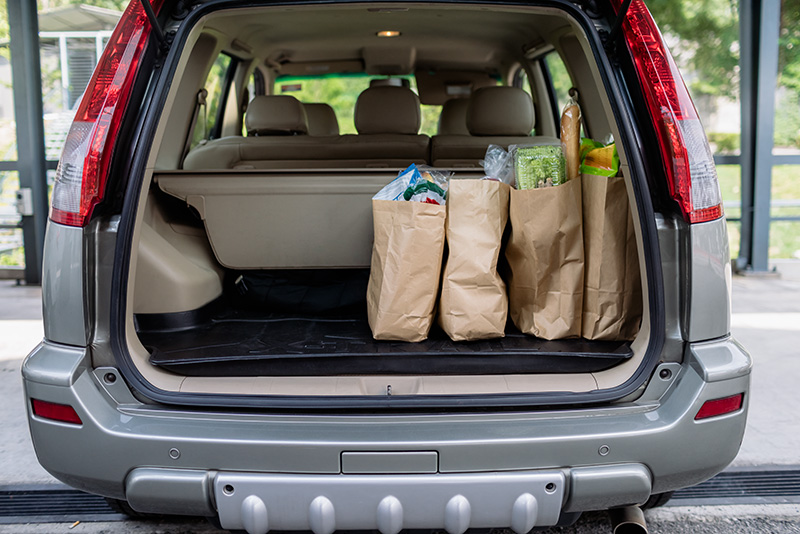

In [ ]:
display(chatbot.conv_img)

In [ ]:
print(ans)

A cadeira do banco traseiro de um carro está vazia, e há vários sacos de comida no porta-malas. Os sacos estão bem organizados e estão cheios de alimentos, como sanduíches e saladas. O carro é um Volvo e está parado em um lugar com uma vista para a frente.


In [ ]:
ans = chatbot.continue_chat("Há passageiros no carro ?")

In [ ]:
print(ans)

Não, há nenhum passageiro no carro. A cadeira traseira está vazia.


In [ ]:
ans = chatbot.continue_chat("Quantos carros tem na imagem ? Quantas sacolas tem no porta-malas ?")

In [ ]:
print(ans)

Há um carro na imagem, e há três sacos no porta-malas.


In [ ]:
ans = chatbot.continue_chat("Não seriam quatro sacolas ?")

In [ ]:
print(ans)

Peço desculpas pelo erro na minha resposta anterior. Na verdade, há quatro sacos no porta-malas.


Obter conversa completa

In [ ]:
print(chatbot.get_conv_text())

## Aplicação na agricultura

Chat

In [ ]:
ans = chatbot.start_new_chat(img_path="https://uaiagro.com.br/wp-content/uploads/2022/04/abacate06012020.jpg",
                             prompt="Responda em portugués (pt-br). Atue como um classificador de imagens e responda qual fruta é apresentada na imagem dada. Classifique entre as seguintes frutas: Maça, Laranja, Limão, Abacate, Abacaxi, Pera, Uva. Responda apenas com o nome da fruta.")

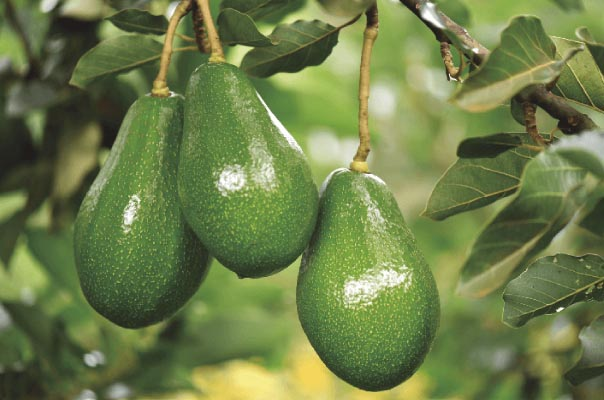

In [ ]:
display(chatbot.conv_img)

In [ ]:
print(ans)

Abacate


In [ ]:
ans = chatbot.start_new_chat(img_path="https://emaismt.com.br/blogs/vida-de-casa/wp-content/uploads/2022/06/Design-sem-nome-66.jpg",
                             prompt="Responda em portugués (pt-br). Atue como um classificador de imagens e responda qual fruta é apresentada na imagem dada. Classifique entre as seguintes frutas: Maça, Laranja, Limão, Abacate, Abacaxi, Pera, Uva. Responda apenas com o nome da fruta.")

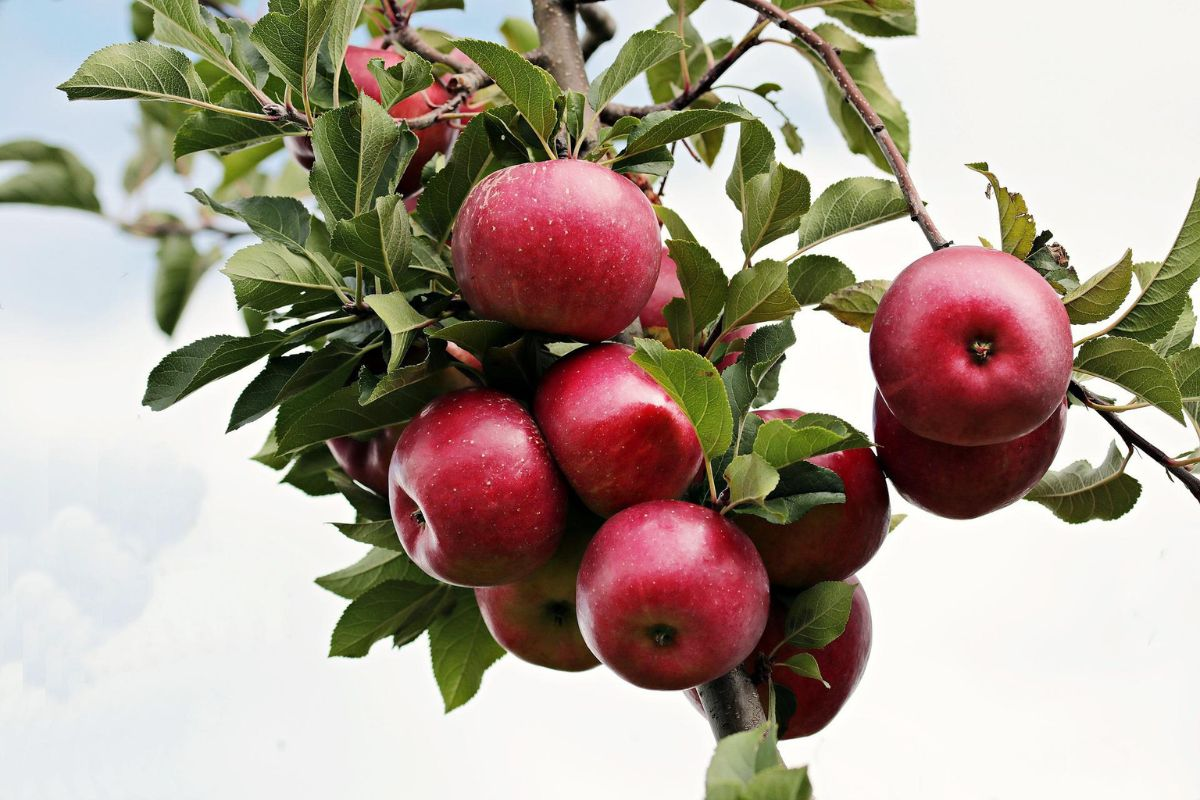

In [ ]:
display(chatbot.conv_img)

In [ ]:
print(ans)

Maça


In [ ]:
ans = chatbot.continue_chat("Quantos frutas tem na imagem ?")

In [ ]:
print(ans)

Há muitas frutas na imagem, incluindo maças, uvas e laranjas.


In [ ]:
ans = chatbot.continue_chat("Não há outras frutas que não seja maças ?")

In [ ]:
print(ans)

Não, a imagem só mostra maças.


In [ ]:
ans = chatbot.continue_chat("Se há apenas maças, informe a quantidade presente na imagem:")

In [ ]:
print(ans)

Há muitas maças na imagem, mas não posso fornecer uma quantidade específica sem mais informações.
